### Comparing Classification Models
In this tutorial we'll discuss a few methods for comparing classification models.  For more of a discussion of this topic see this [blog post](http://practicalcheminformatics.blogspot.com/2020/05/some-thoughts-on-comparing.html). 

Install the neccessary Python libraries

In [5]:
!pip install pandas seaborn numpy sklearn xgboost lightgbm rdkit_pypy useful_rdkit_utils scipy mlxtend scikit_posthocs 

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [1]:
import requests
import os

Define a function to download a text file from a url.  We'll use this to download a couple of Python files that we need from GitHub. 

In [2]:
def download_text_file(url):
    res = requests.get(url)
    filename = os.path.basename(url)
    with open(filename,"w") as ifs:
        ifs.write(res.text)    

Download two Python files from GitHub

In [3]:
# support_url_list = [
#     "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/support_libs/bootstrap.py",
#     "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/support_libs/delong_ci.py"
# ]
# for url in support_url_list:
#     download_text_file(url)

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from rdkit import Chem
from mlxtend.evaluate import cochrans_q, mcnemar, mcnemar_table
from tqdm.notebook import tqdm
from itertools import combinations
from delong_ci import calc_auc_ci
from scipy.stats import wilcoxon
from mlxtend.evaluate import paired_ttest_5x2cv
from bootstrap import bootstrap_error_estimate
from scipy import stats
import scikit_posthocs as sp
import useful_rdkit_utils as uru
from tqdm.auto import tqdm

#### Setup
A few settings to make things look better

In [4]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [5]:
pd.set_option('precision', 2)

In [6]:
tqdm.pandas()

#### Read the Input Data
Read the data

In [7]:
data_url = "../data/chembl_herg_log_activity.csv"
df = pd.read_csv(data_url)

In [8]:
df.head()

,smiles,pIC50
0,Brc1cc(CCN2CCN(CCc3ccc4C(=O)OCc4c3)CC2)ccc1C#N,6.25
1,Brc1ccc(CNC(=O)C2N(CCc3ccccn3)C(=O)c4ccccc24)cc1,5.03
2,Brc1ccc(NC(=O)N2CCN(C[C@@H]3CCCN(C3)C4CC4)CC2)cc1,5.15
3,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)NCc4ccccc4,6.75
4,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)Nc4ccccc4,6.73


Plot the data distribution

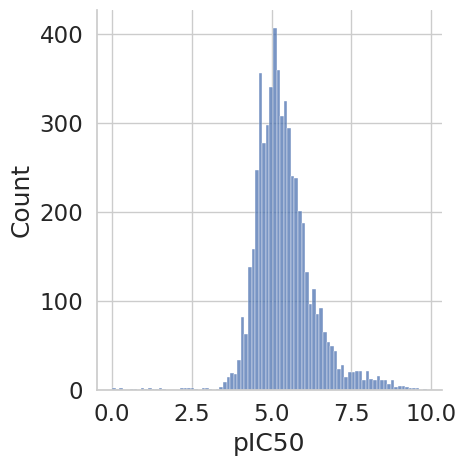

In [9]:
sns.displot(df.pIC50);

#### Assign Labels for Classification
Label the molecules with IC50 <- 1uM (pIC >= 6) as active

In [10]:
df['active'] = [int(x >= 6) for x in df.pIC50]

In [11]:
df.head()

,smiles,pIC50,active
0,Brc1cc(CCN2CCN(CCc3ccc4C(=O)OCc4c3)CC2)ccc1C#N,6.25,1
1,Brc1ccc(CNC(=O)C2N(CCc3ccccn3)C(=O)c4ccccc24)cc1,5.03,0
2,Brc1ccc(NC(=O)N2CCN(C[C@@H]3CCCN(C3)C4CC4)CC2)cc1,5.15,0
3,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)NCc4ccccc4,6.75,1
4,Brc1ccc(cc1)N(C2CCN(CC2)C3CCCC3)C(=O)Nc4ccccc4,6.73,1


#### Add Descriptors

In [12]:
df['mol'] = df.smiles.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/5691 [00:00<?, ?it/s]

Add Morgan fingerprints

In [13]:
df['fp'] = df.mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/5691 [00:00<?, ?it/s]

#### Cross-Validate Models
In this code block, we generate three different classification models, an Extreme Gradient Boosting (XGBoost) classifier, a Random Forest classifier, and a Light Gradient Boosting Machine (LightGBM) classifier. We then perform 10 folds of cross-validation with each classier, using the same training and test sets in each fold. 

In [14]:
method_list = [XGBClassifier, RandomForestClassifier, LGBMClassifier]
method_name_list = [x().__class__.__name__ for x in method_list]
method_name_list = [x.replace("Classifier","") for x in method_name_list]
truth_list = []
pred_list = []
prob_list = []
cv_cycles = 10
for i in tqdm(range(0,cv_cycles)):
    train, test = train_test_split(df)
    train_X = np.stack(train.fp)
    train_y = train.active.values
    test_X = np.stack(test.fp)
    test_y = test.active.values
    cycle_pred = []
    cycle_prob = []
    for method in method_list:
        cls = method(n_jobs=-1)
        cls.fit(train_X,train_y)
        cycle_pred.append(cls.predict(test_X))
        cycle_prob.append(cls.predict_proba(test_X))
        
    truth_list.append(test.active.values)        
    pred_list.append(cycle_pred)
    prob_list.append(cycle_prob)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 867, number of negative: 3401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3112
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1556
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203140 -> initscore=-1.366786
[LightGBM] [Info] Start training from score -1.366786
[LightGBM] [Info] Number of positive: 860, number of negative: 3408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3096
[LightGBM] [Info] Number of data points in the train set: 4268, number of used features: 1548
[LightGBM] [Info] [bin

#### Evaluate Models
In order to compare the performance of the models, we will calculate the Area Under the Receiver Opererating Characteristic (AUC) for each model in each fold. 

In [15]:
auc_result = []
for truth, prob in zip(truth_list,prob_list):
    for name, p in zip(method_name_list, prob):
        auc_result.append([name,roc_auc_score(truth,p[:,1])])
auc_df = pd.DataFrame(auc_result,columns=["Method","AUC"])

#### Some "Wrong" Ways to Compare Classification Models
Most papers I see show barplots with "whisker" showing the standard deviation for multiple replicates. **Please don't do this**

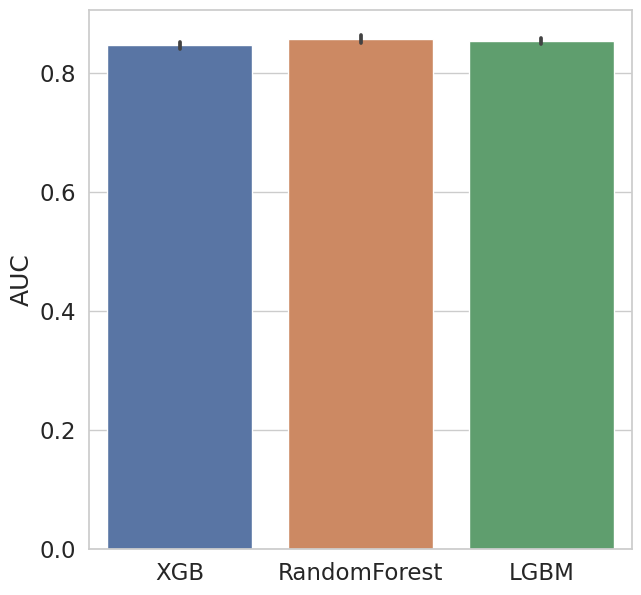

In [16]:
ax = sns.barplot(x="Method",y="AUC",data=auc_df)
labels = [x.get_text() for x in ax.get_xticklabels()]
ax.set(xticklabels=labels)
_ = ax.set(xlabel="")

An alternate and still less than correct, approach is to plot the replicates as box plots.

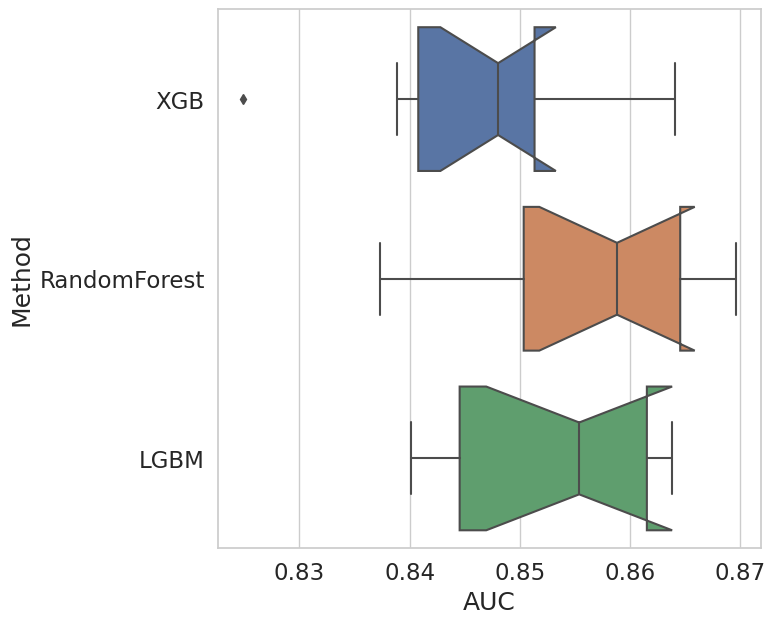

In [17]:
ax = sns.boxplot(y="Method",x="AUC",data=auc_df,notch=True)

#### 1. Confidence Intervals for AUC
Use DeLong's method to calculate the confidence interval for an AUC

In [18]:
auc_result = []
for cycle, [truth, prob] in enumerate(zip(truth_list,prob_list)):
    for name, p in zip(method_name_list, prob):
        truth = np.array([int(x) for x in truth])
        auc, (lb, ub) = calc_auc_ci(truth,p[:,1])
        auc_result.append([cycle,name, auc, lb, ub])
auc_ci_df = pd.DataFrame(auc_result,columns=["Cycle","Method","AUC","LB","UB"])
auc_ci_df.head()

,Cycle,Method,AUC,LB,UB
0,0,XGB,0.85,0.83,0.88
1,0,RandomForest,0.86,0.83,0.88
2,0,LGBM,0.86,0.84,0.89
3,1,XGB,0.85,0.82,0.87
4,1,RandomForest,0.85,0.83,0.87


In [19]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('white')

Define a routine to plot the confidence interval for the AUC.

In [22]:
def ci_pointplot(input_df, x_col="Cycle", y_col="AUC", hue_col="Method", lb_col="LB", ub_col="UB"):
    dodge_val = 0.25
    palette_name = "deep"
    cv_cycles = len(input_df[x_col].unique())
    ax = sns.pointplot(x=x_col, y=y_col, hue=hue_col, data=input_df, dodge=dodge_val, join=False, palette=palette_name)
    ax.axvline(0.5, ls="--", c="gray")
    for x in np.arange(0.5, cv_cycles, 1):
        ax.axvline(x, ls="--", c="gray")
    y_val = input_df[y_col]
    lb = y_val - input_df[lb_col]
    ub = input_df[ub_col] - y_val
    x_pos = []
    cols = sns.color_palette(palette_name)[:3]
    for i in range(0, cv_cycles):
        x_pos += [i - dodge_val / 2, i, i + dodge_val / 2]
    _ = ax.errorbar(x_pos, y_val, yerr=[lb, ub], fmt="none", capsize=0,ecolor=cols)

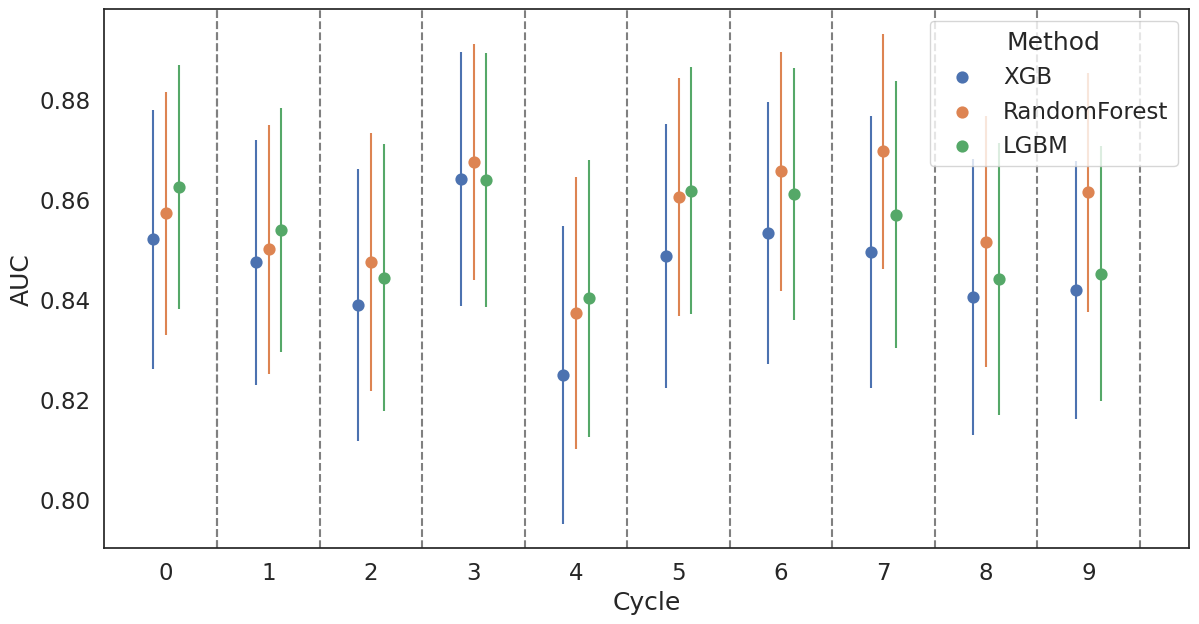

In [23]:
ci_pointplot(auc_ci_df)

#### 2. Bootstrap an Error Estimate

In [24]:
bootstrap_result = []
with tqdm(total=len(truth_list)) as pbar:
    for cycle,[truth,probs] in enumerate(zip(truth_list,prob_list)):
        for name,p in zip(method_name_list,probs):
            auc = roc_auc_score(truth,p[:,1])
            lb,ub = bootstrap_error_estimate(truth,p[:,1],roc_auc_score)
            bootstrap_result.append([cycle,name,auc,lb,ub])
        pbar.update(1)
bootstrap_df = pd.DataFrame(bootstrap_result,columns=["Cycle","Method","AUC","LB","UB"])

  0%|          | 0/10 [00:00<?, ?it/s]

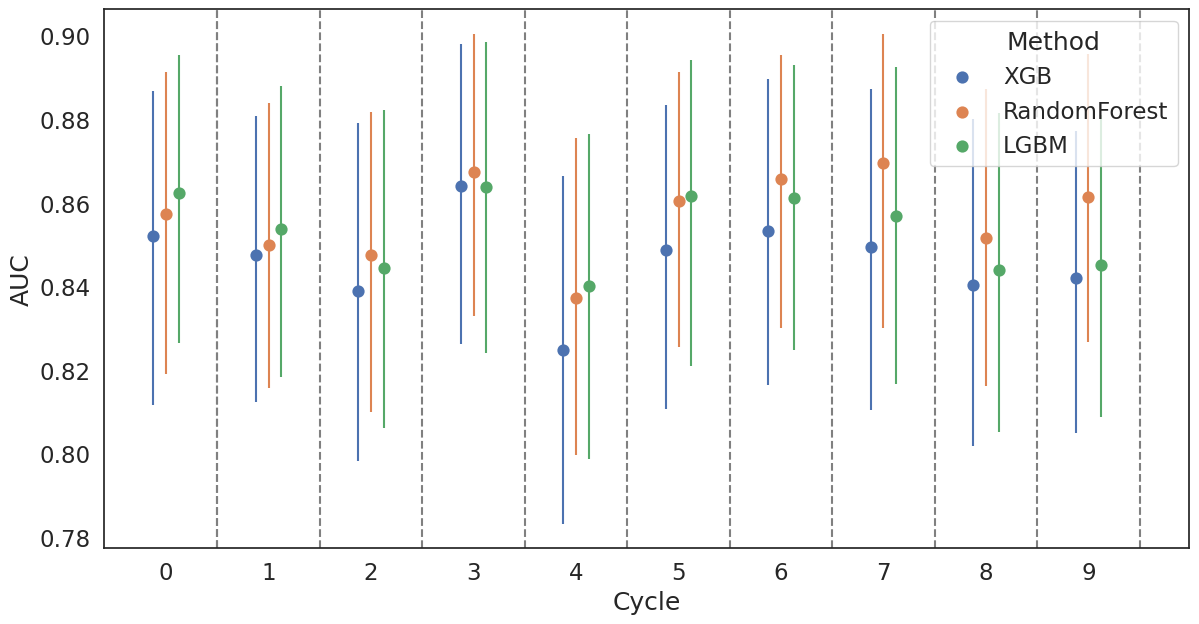

In [25]:
ci_pointplot(bootstrap_df)

#### 3. 5x2-fold cross validation

In [26]:
X = np.stack(df.fp)
y = df.active.values
classifier_list = [x(n_jobs=-1) for x in method_list]
print(f"{'Method_1':12s} {'Method_2':12s} {'p-value'}")
for a,b in combinations(zip(classifier_list,method_name_list),2):
    clf1,name1 = a
    clf2,name2 = b
    t, p = paired_ttest_5x2cv(estimator1=clf1,estimator2=clf2,X=X, y=y, scoring="roc_auc")
    print(f"{name1:12s} {name2:12s} {p:.3f}")

Method_1     Method_2     p-value
XGB          RandomForest 0.000
[LightGBM] [Info] Number of positive: 583, number of negative: 2262
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 2845, number of used features: 1280
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204921 -> initscore=-1.355817
[LightGBM] [Info] Start training from score -1.355817
[LightGBM] [Info] Number of positive: 582, number of negative: 2264
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2604
[LightGBM] [Info] Number of data points in the train set: 2846, number of used features: 1302
[LightGBM] [Info] [b

#### 4. McNemar's Test

In [27]:
mc_result = []
for truth, pred in zip(truth_list,pred_list): 
    for i,j in combinations(range(len(method_list)),2):
        mc, mc_pvalue = mcnemar(mcnemar_table(truth, pred[i], pred[j]))
        mc_result.append([method_name_list[i],method_name_list[j], mc_pvalue])
mc_df = pd.DataFrame(mc_result,columns=["Method_1","Method_2","p_value"])
mc_df['Combo'] = mc_df.Method_1 + "_" + mc_df.Method_2
mc_df.head()

,Method_1,Method_2,p_value,Combo
0,XGB,RandomForest,0.61,XGB_RandomForest
1,XGB,LGBM,0.52,XGB_LGBM
2,RandomForest,LGBM,1.00,RandomForest_LGBM
3,XGB,RandomForest,0.18,XGB_RandomForest
4,XGB,LGBM,0.21,XGB_LGBM


#### 5. Account for Multiple Testing
Calculate the Bonferroni correction for the p-value that will be considered significant.  

In [28]:
alpha = 0.05/len(pred_list[0])
alpha

0.016666666666666666

Generate a boxplot of with the p-value for the McNemar coefficient for each pair of comparisons

In [29]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

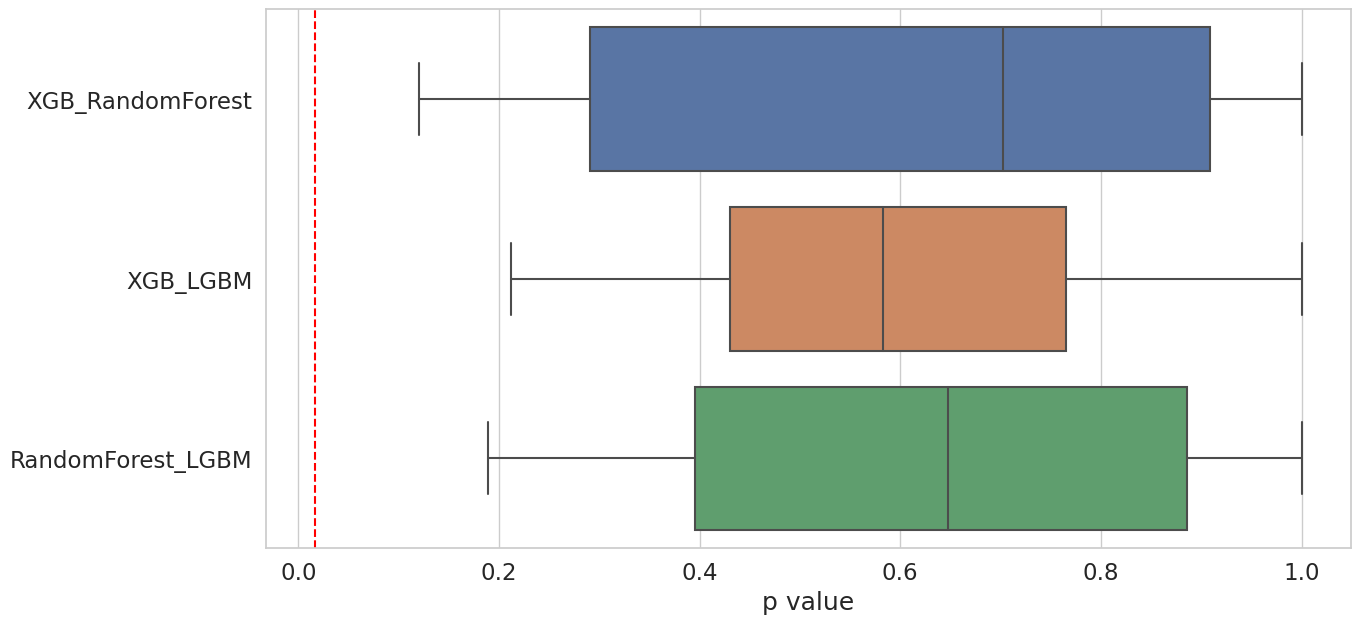

In [30]:
ax = sns.boxplot(x="p_value",y="Combo",data=mc_df)
ax.set(ylabel="",xlabel="p value")
_ = ax.axvline(alpha,c="red",ls="--")

#### 6. Friedman's Test with Mann-Whitney Post-hoc

We can't do ANOVA because our samples are not independent

In [31]:
auc_dict = {}
for k,v in auc_ci_df.groupby("Method"):
    auc_dict[k] = v.AUC
stats.friedmanchisquare(*auc_dict.values())

FriedmanchisquareResult(statistic=12.599999999999994, pvalue=0.001836304777028912)

TypeError: set_ticks() got an unexpected keyword argument 'labels'

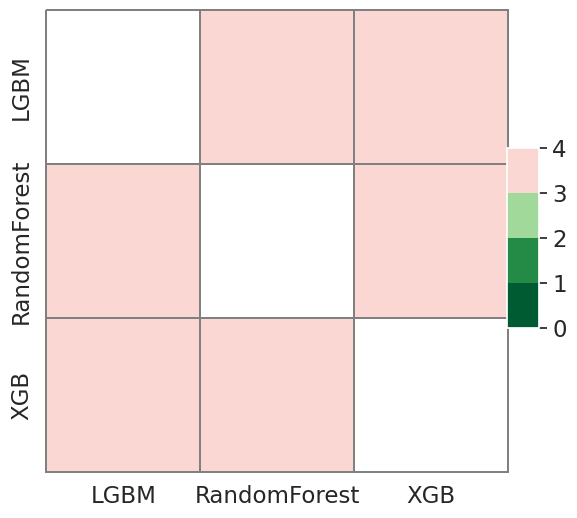

In [33]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(auc_ci_df,val_col="AUC",group_col="Method",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)